In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'dataset/liver.h5ad'
# the liver data is downloaded from https://github.com/BaderLab/HumanLiver/raw/master/inst/liver/HumanLiver.RData
# in R,
# do
# load('HumanLiver.RData')
# HumanLiverSeurat[['ica']] <- NULL
# sceasy::convertFormat(HumanLiverSeurat, from="seurat", to="anndata", outFile='liver.h5ad', main_layer = 'counts')

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 8444 × 20007 
    obs: 'total_counts', 'total_features', 'orig.ident', 'res.0.8', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'
    obsm: 'X_pca', 'X_tsne'

In [10]:
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_total(adata)
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. 
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


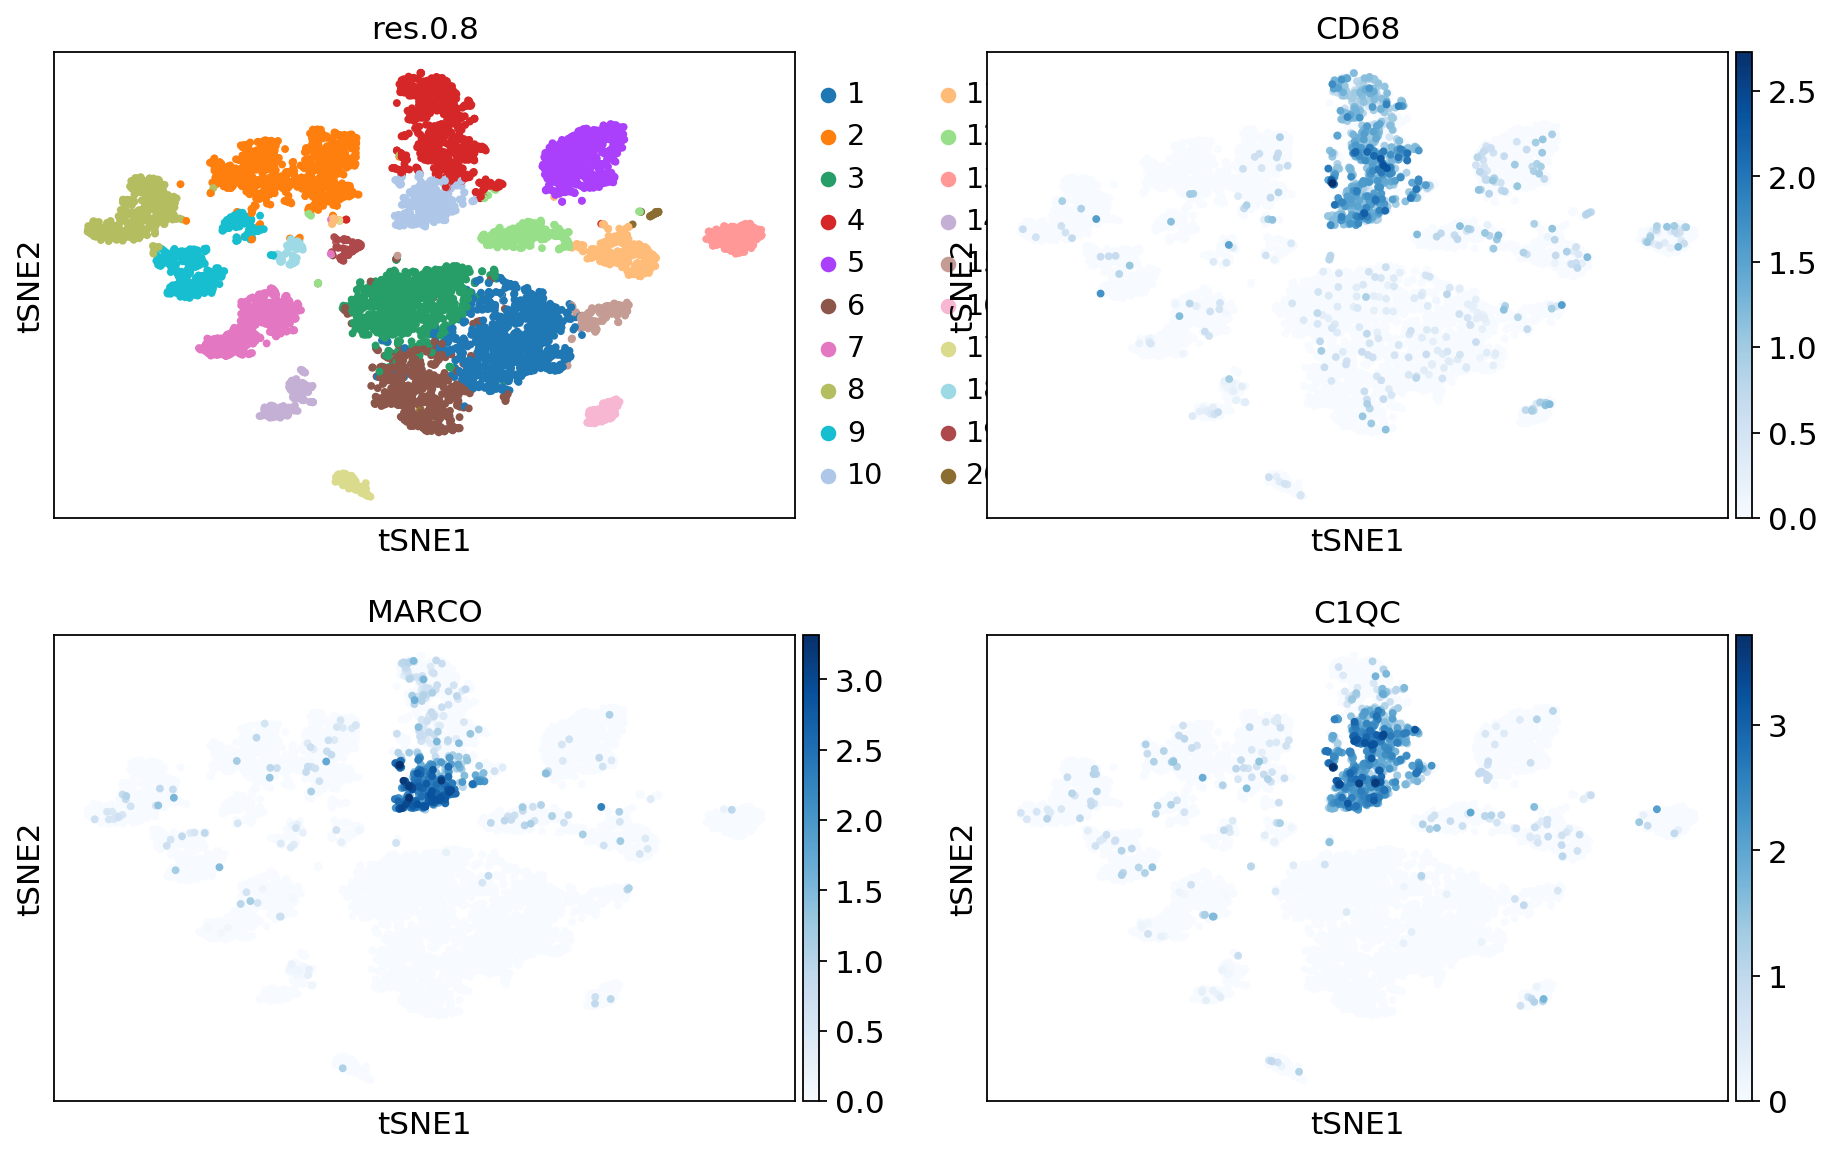

In [13]:
sc.pl.tsne(adata, color = ['res.0.8', 'CD68', 'MARCO', 'C1QC'], color_map = 'Blues', size = 50, ncols = 2)

categories: 1, 2, 3, etc.
var_group_labels: Hepatocytes, LSECs, Cholangiocytes, etc.


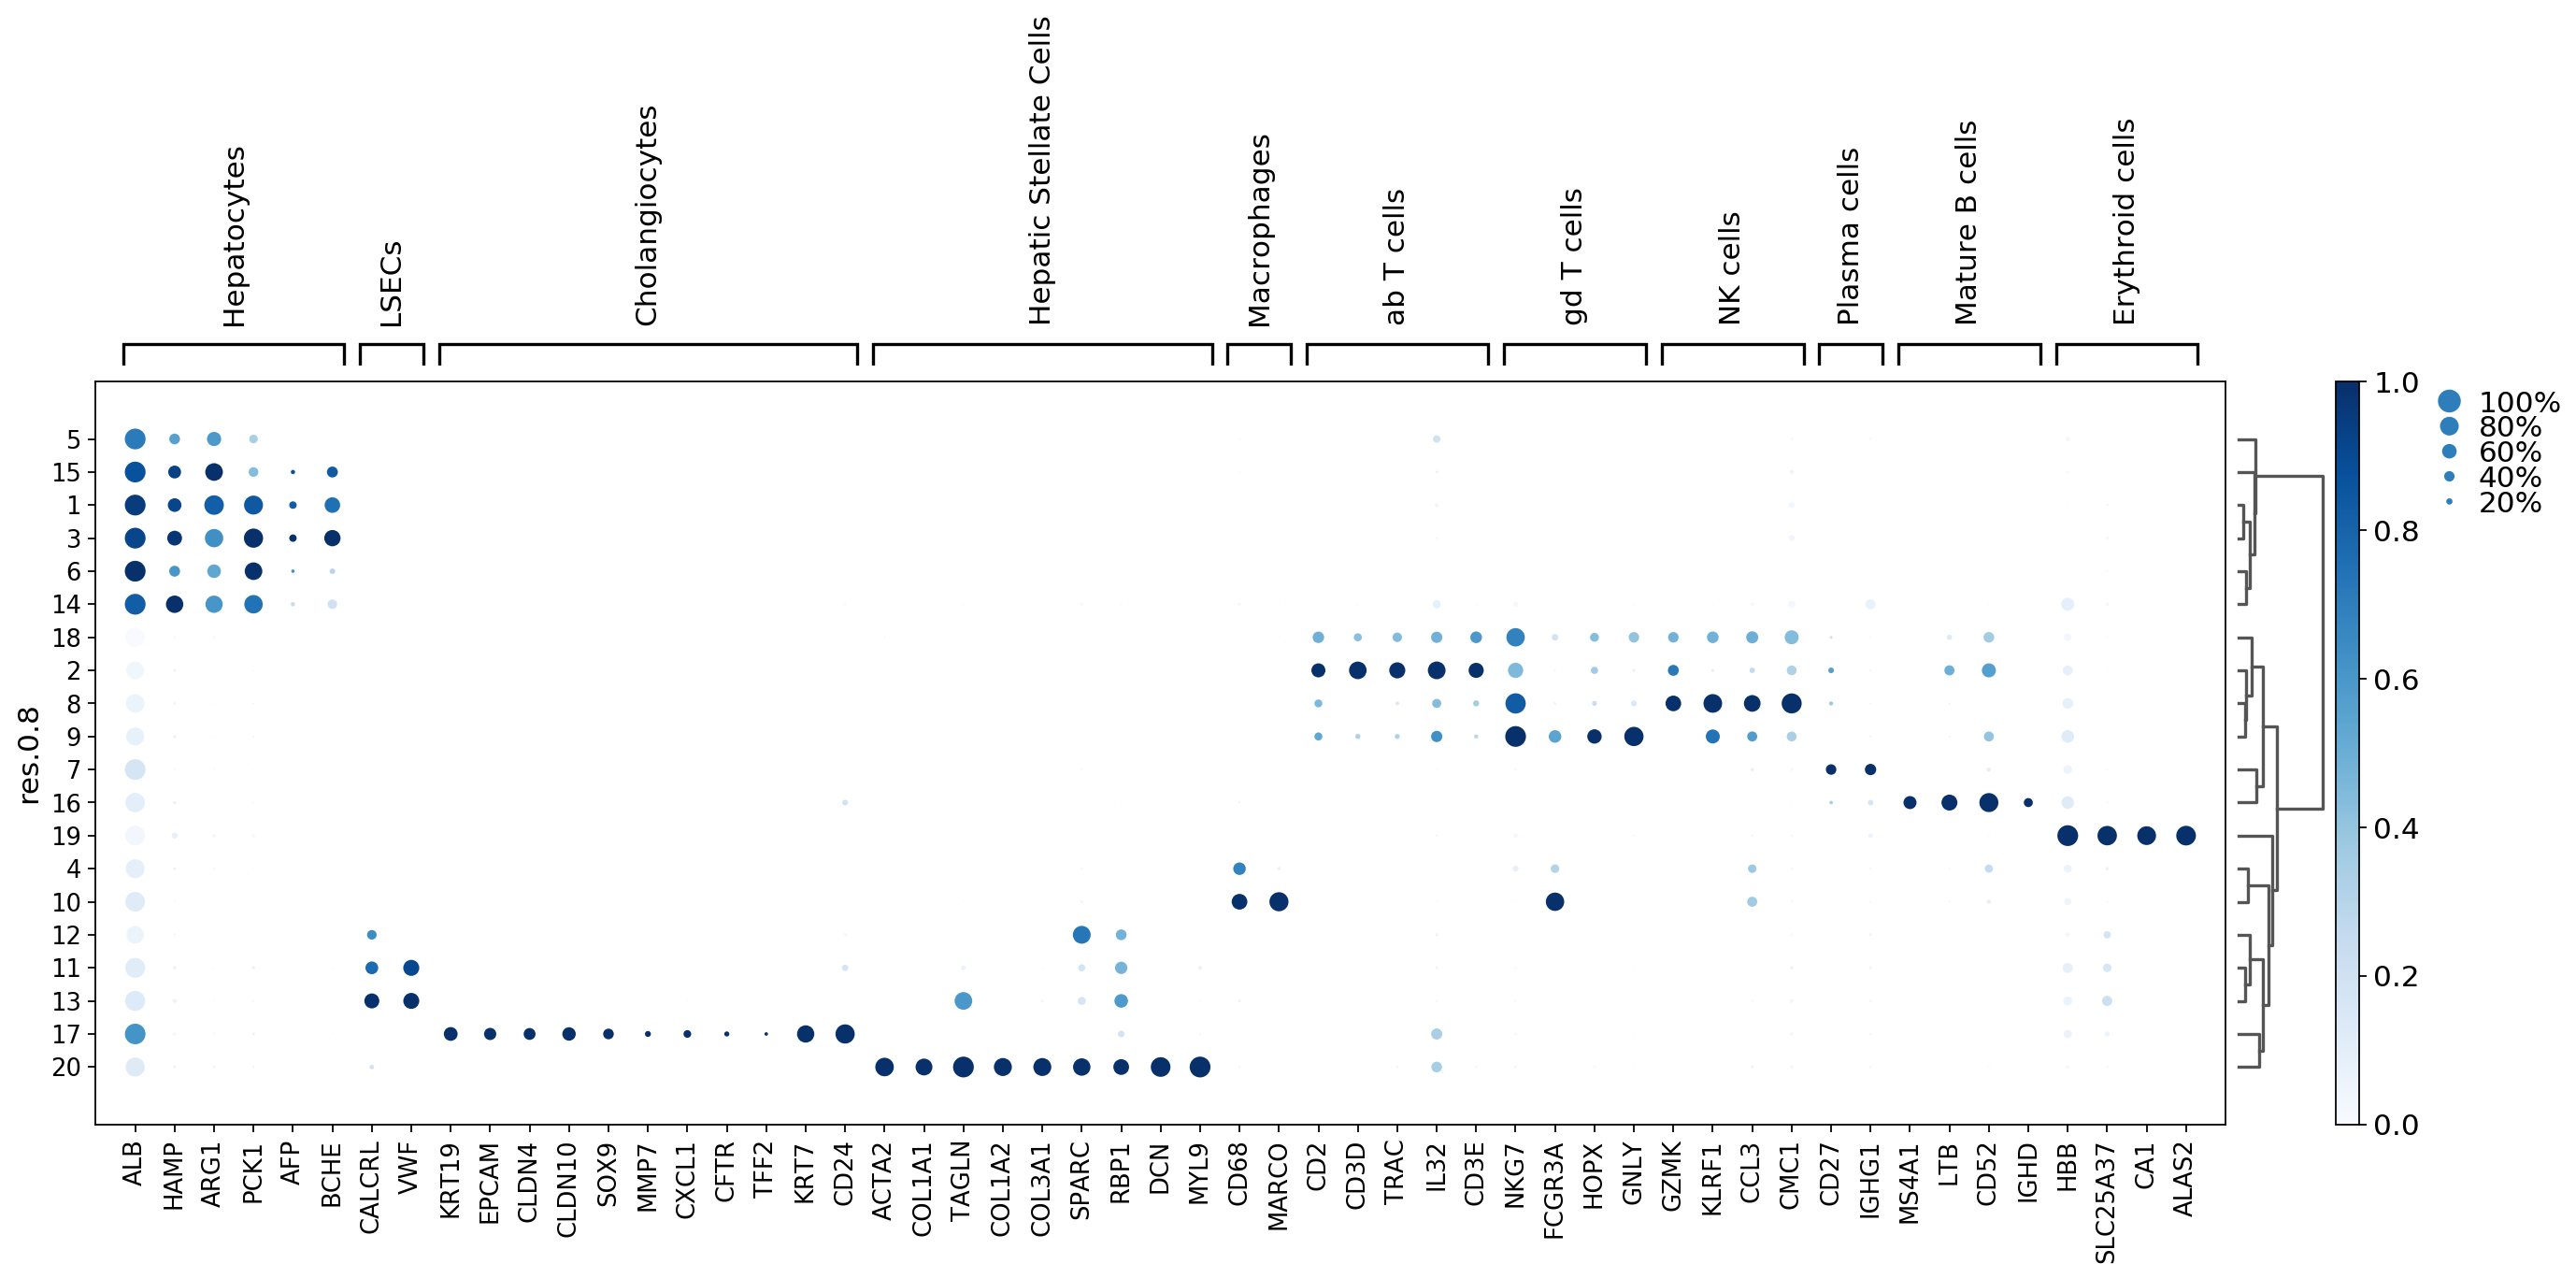

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[18.549999999999997, 0.8, 0.2, 0.5, 0.25])

In [14]:
markers = {"Hepatocytes":["ALB","HAMP","ARG1","PCK1","AFP","BCHE"],
    "LSECs":["CALCRL","VWF"],
    "Cholangiocytes":["KRT19","EPCAM","CLDN4","CLDN10","SOX9","MMP7","CXCL1","CFTR","TFF2","KRT7","CD24"],
    "Hepatic Stellate Cells":["ACTA2","COL1A1","TAGLN","COL1A2","COL3A1","SPARC","RBP1","DCN","MYL9"],
    "Macrophages":["CD68","MARCO"],
    "ab T cells":["CD2","CD3D","TRAC","IL32","CD3E"],
    "gd T cells":["NKG7","FCGR3A","HOPX","GNLY"],
    "NK cells":["GZMK","KLRF1","CCL3","CMC1"],
    "Plasma cells":["CD27","IGHG1"],
    "Mature B cells":["MS4A1","LTB","CD52","IGHD"],
    "Erythroid cells":["HBB","SLC25A37","CA1","ALAS2"]}
sc.pl.dotplot(adata, markers, groupby = 'res.0.8', color_map = 'Blues', standard_scale = 'var', dendrogram = True)

In [15]:
# subset to just the macrophages
adata = adata[adata.obs['res.0.8'].isin(['4','10'])]
adata

View of AnnData object with n_obs × n_vars = 1192 × 20007 
    obs: 'total_counts', 'total_features', 'orig.ident', 'res.0.8', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'
    uns: 'log1p', 'res.0.8_colors', 'dendrogram_res.0.8'
    obsm: 'X_pca', 'X_tsne'

In [16]:
# save first
adata.write('dataset/liver.h5ad', compression = 'gzip')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'dataset/liver.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 1192 × 20007 
    obs: 'total_counts', 'total_features', 'orig.ident', 'res.0.8', 'S.Score', 'G2M.Score', 'Phase', 'Mac1_score', 'Mac2_score', 'Mac-MT1_score', 'Mono_score', 'DC_score', 'Mac-cycling_score'
    var: 'name'
    uns: 'dendrogram_res.0.8', 'res.0.8_colors'
    obsm: 'X_pca', 'X_tsne'

In [2]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [3]:
# now compute Mac-MT1 score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(adata.obs['Mac-MT1_score'])
mask = adata.obs['Mac-MT1_score']>med
mad = np.median(adata.obs['Mac-MT1_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(adata.obs['Mac-MT1_score'], loc=med, scale=1.4826*mad)
adata.obs['bh_pval'] = bh(pvals)

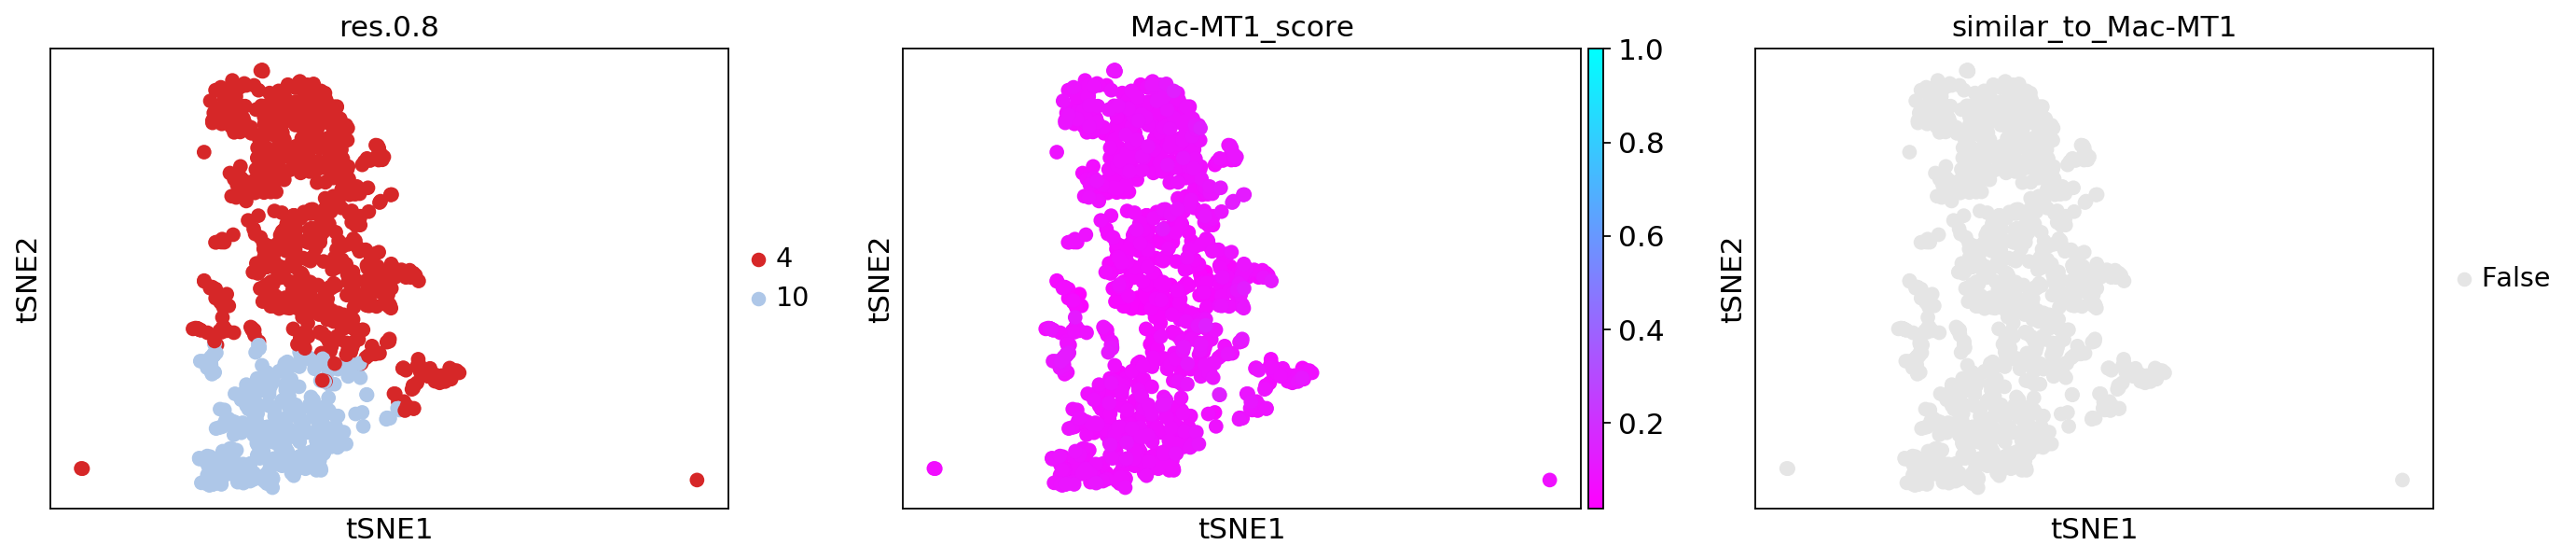

In [4]:
# threshold the p-values to get potential Mac-MT1 calls.
adata.obs['similar_to_Mac-MT1'] = (adata.obs['bh_pval'] < 0.05) & (adata.obs['Mac-MT1_score'] > 0.5)
adata.obs['similar_to_Mac-MT1'] = adata.obs['similar_to_Mac-MT1'].astype('category')
# visualise the Mac-MT1
adata.uns['similar_to_Mac-MT1_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
if not os.path.exists('figures/tsne/'):
    os.makedirs('figures/tsne')
sc.pl.tsne(adata, color = ['res.0.8', 'Mac-MT1_score', 'similar_to_Mac-MT1'], size = 200, save = '/Liver_similarity_to_Mac-MT1.pdf', color_map = 'cool_r', vmax = 1)

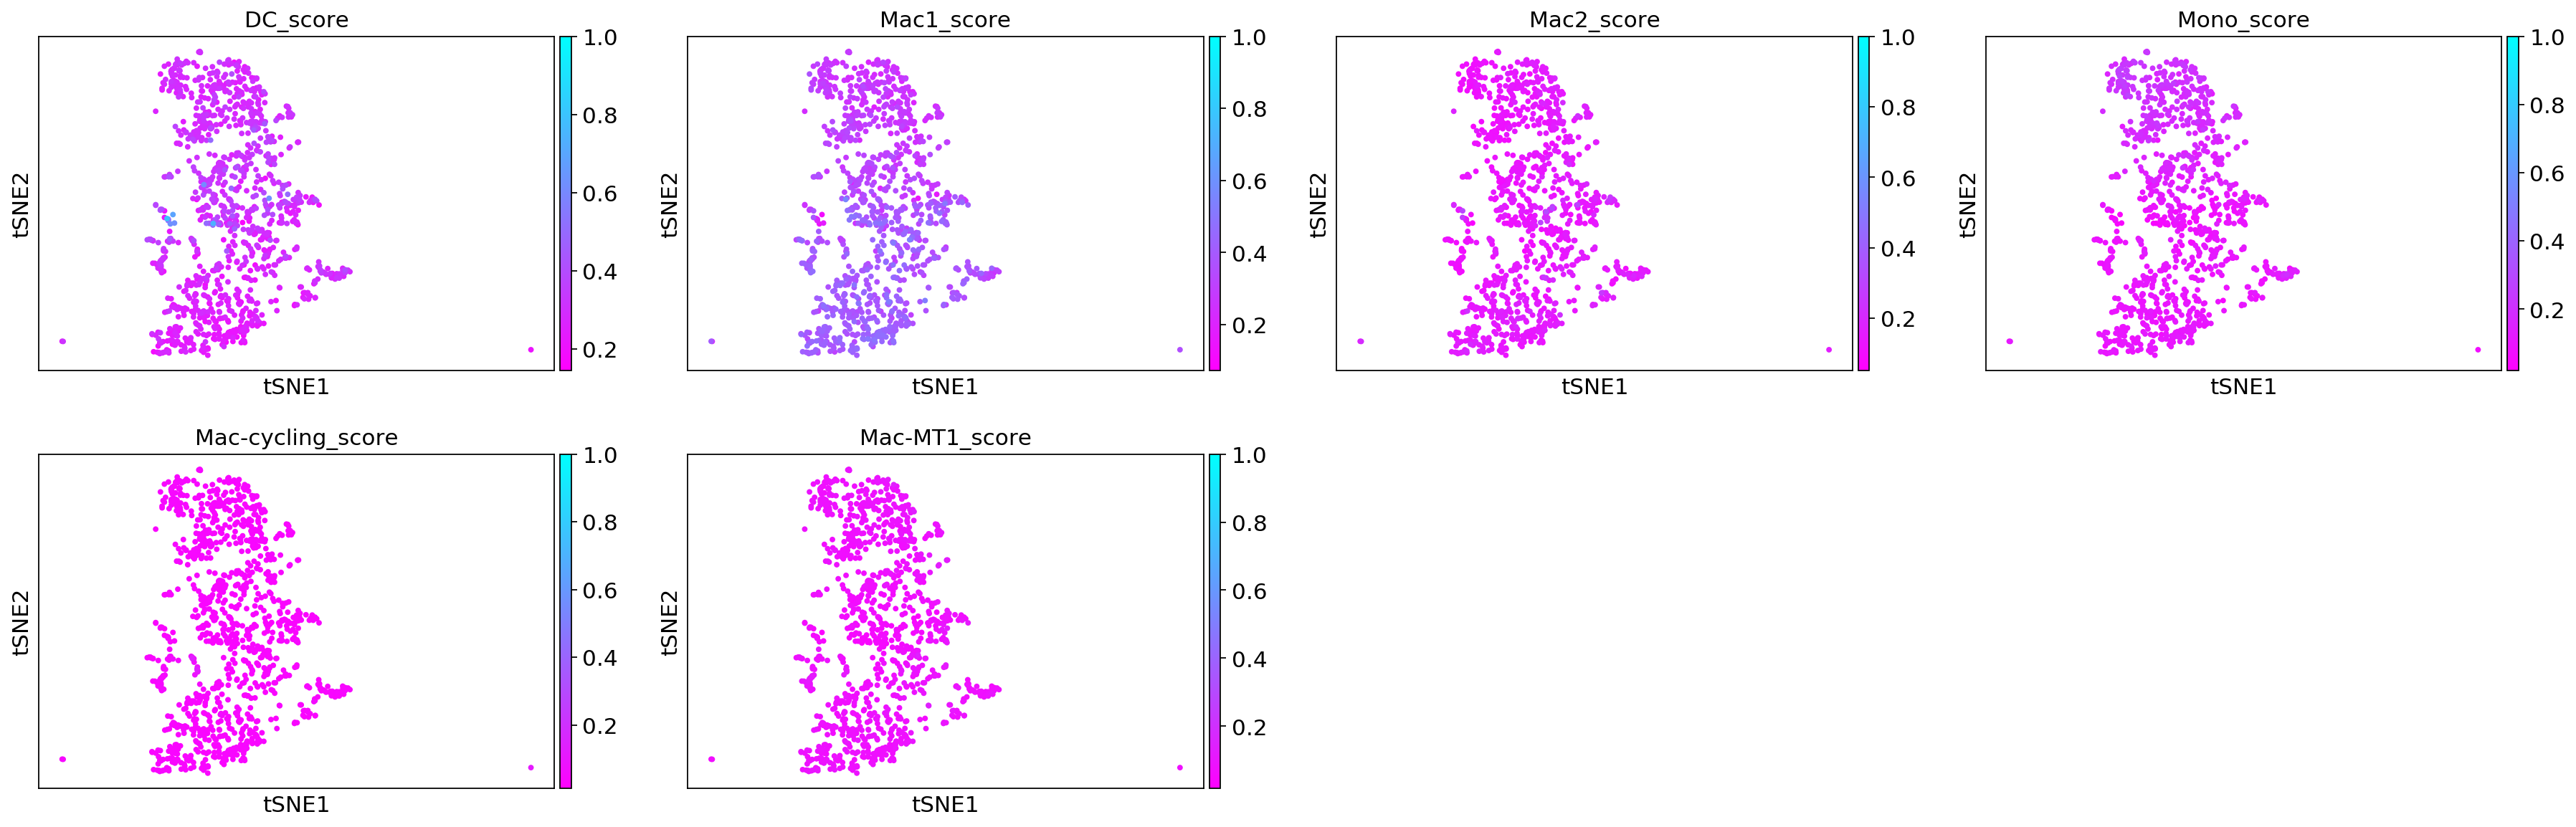

In [23]:
sc.pl.tsne(adata, color = ['DC_score', 'Mac1_score', 'Mac2_score', 'Mono_score', 'Mac-cycling_score', 'Mac-MT1_score'], size =50, color_map = 'cool_r', vmax = 1)